In [1]:
import os
import shutil
from PIL import Image
import numpy as np
import hashlib

# Original (read-only)
INPUT_TRAIN_PATH = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"
INPUT_TEST_PATH  = "/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test"

# Working (writable)
WORKING_DIR = "/kaggle/working/deepfake_cleaned"
TRAIN_PATH = os.path.join(WORKING_DIR, "train")
TEST_PATH  = os.path.join(WORKING_DIR, "test")

CLASSES = ["real", "fake"]
def copy_dataset(src, dst):
    """
    Copies dataset from read-only input to writable working directory.
    """
    if not os.path.exists(dst):
        shutil.copytree(src, dst)
        print(f"✔ Dataset copied from {src} to {dst}")
    else:
        print(f"✔ Dataset already exists at {dst}")

copy_dataset(INPUT_TRAIN_PATH, TRAIN_PATH)
copy_dataset(INPUT_TEST_PATH, TEST_PATH)
def remove_corrupted_images(dataset_path):
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1

    print(f"✔ Removed {removed} corrupted images from {dataset_path}")
def remove_exact_duplicates(dataset_path):
    hashes = {}
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            with open(file_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in hashes:
                os.remove(file_path)
                removed += 1
            else:
                hashes[file_hash] = file_path

    print(f"✔ Removed {removed} duplicate images from {dataset_path}")
def remove_corrupted_images(dataset_path):
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1

    print(f"✔ Removed {removed} corrupted images from {dataset_path}")

remove_corrupted_images(TRAIN_PATH)
remove_corrupted_images(TEST_PATH)

remove_exact_duplicates(TRAIN_PATH)
remove_exact_duplicates(TEST_PATH)


✔ Dataset copied from /kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train to /kaggle/working/deepfake_cleaned/train
✔ Dataset copied from /kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test to /kaggle/working/deepfake_cleaned/test
✔ Removed 0 corrupted images from /kaggle/working/deepfake_cleaned/train
✔ Removed 0 corrupted images from /kaggle/working/deepfake_cleaned/test
✔ Removed 3 duplicate images from /kaggle/working/deepfake_cleaned/train
✔ Removed 1 duplicate images from /kaggle/working/deepfake_cleaned/test


In [2]:
import os

TRAIN_PATH = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"

classes = [
    d for d in os.listdir(TRAIN_PATH)
    if os.path.isdir(os.path.join(TRAIN_PATH, d))
]

print("Detected classes:", classes)


Detected classes: ['fake', 'real']


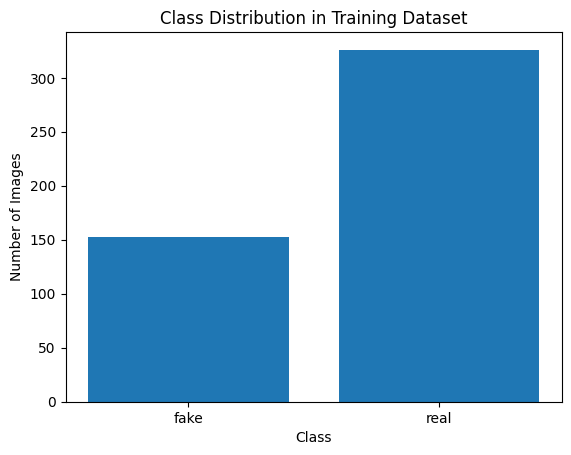

In [3]:
import matplotlib.pyplot as plt

counts = []
for label in classes:
    class_path = os.path.join(TRAIN_PATH, label)
    counts.append(len(os.listdir(class_path)))

plt.figure()
plt.bar(classes, counts)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


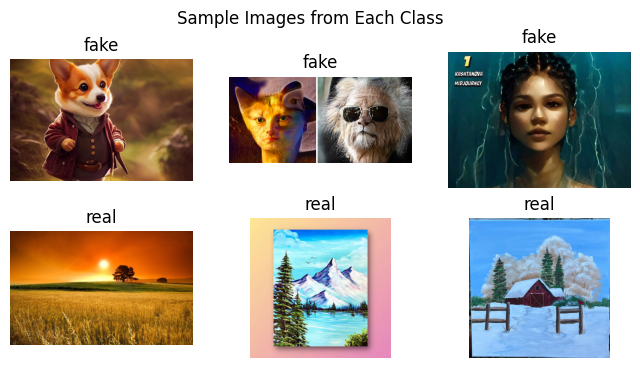

In [4]:
import random
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
idx = 1

for label in classes:
    folder = os.path.join(TRAIN_PATH, label)
    samples = random.sample(os.listdir(folder), 3)

    for img_name in samples:
        img = Image.open(os.path.join(folder, img_name))
        plt.subplot(len(classes), 3, idx)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
        idx += 1

plt.suptitle("Sample Images from Each Class")
plt.show()


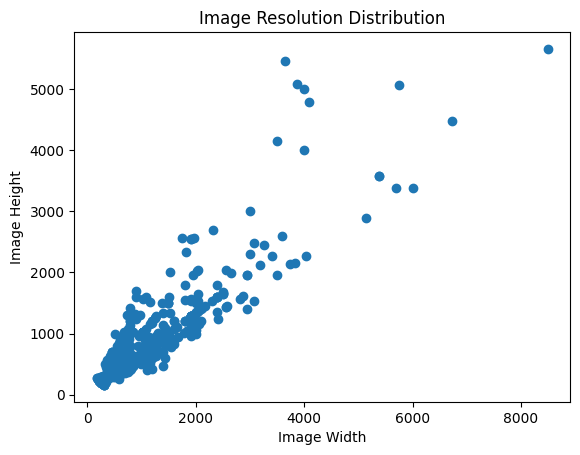

In [5]:
widths, heights = [], []

for label in classes:
    folder = os.path.join(TRAIN_PATH, label)
    for img_name in os.listdir(folder):
        img = Image.open(os.path.join(folder, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure()
plt.scatter(widths, heights)
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Image Resolution Distribution")
plt.show()


In [6]:
import os
import hashlib

def find_exact_duplicates(root_dir):
    hashes = {}
    duplicates = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(root, file)
                with open(path, "rb") as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()

                if file_hash in hashes:
                    duplicates.append((hashes[file_hash], path))
                else:
                    hashes[file_hash] = path

    return duplicates

In [7]:
DATASET_PATH = "/kaggle/working/deepfake_cleaned"
duplicates = find_exact_duplicates(DATASET_PATH)

print("Exact duplicates found:", len(duplicates))
for dup in duplicates[:5]:
    print(dup)

Exact duplicates found: 0


In [8]:
#data augmentation

import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Configuration
SOURCE_PATH = "/kaggle/working/deepfake_cleaned/train"
OUTPUT_PATH = "/kaggle/working/deepfake_augmented/train"
CLASSES = ["real", "fake"]

AUGMENT_CONFIG = {
    "real": 2,
    "fake": 5
}

def rotate_image(image, angle):
    """Rotate image by given angle"""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h))

def flip_image(image, flip_code):
    """Flip image (0=vertical, 1=horizontal, -1=both)"""
    return cv2.flip(image, flip_code)

def adjust_brightness(image, factor):
    """Adjust brightness by multiplying pixel values"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = hsv.astype(np.float32)
    hsv[:, :, 2] = hsv[:, :, 2] * factor
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    hsv = hsv.astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def add_noise(image, noise_level=25):
    """Add Gaussian noise to image"""
    noise = np.random.randn(*image.shape) * noise_level
    noisy_image = image.astype(np.float32) + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def apply_blur(image, kernel_size=5):
    """Apply Gaussian blur"""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def augment_image(image, aug_type):
    """Apply specific augmentation based on type"""
    augmentations = {
        0: lambda img: flip_image(img, 1),  # Horizontal flip
        1: lambda img: rotate_image(img, np.random.randint(-15, 15)),  # Random rotation
        2: lambda img: adjust_brightness(img, np.random.uniform(0.8, 1.2)),  # Brightness
        3: lambda img: add_noise(img, np.random.randint(10, 30)),  # Noise
        4: lambda img: apply_blur(img, np.random.choice([3, 5])),  # Blur
    }
    
    # Apply random combination
    num_transforms = np.random.randint(1, 4)
    selected_transforms = np.random.choice(len(augmentations), num_transforms, replace=False)
    
    result = image.copy()
    for transform_idx in selected_transforms:
        result = augmentations[transform_idx](result)
    
    return result

def augment_dataset():
    """Augment the entire dataset"""
    
    for class_name in CLASSES:
        os.makedirs(os.path.join(OUTPUT_PATH, class_name), exist_ok=True)
    
    for class_name in CLASSES:
        source_class_path = os.path.join(SOURCE_PATH, class_name)
        output_class_path = os.path.join(OUTPUT_PATH, class_name)
        
        image_files = [f for f in os.listdir(source_class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"\nProcessing class: {class_name}")
        print(f"Found {len(image_files)} images")
        
        for img_file in tqdm(image_files, desc=f"Augmenting {class_name}"):
            img_path = os.path.join(source_class_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            # Save original
            base_name = Path(img_file).stem
            ext = Path(img_file).suffix
            cv2.imwrite(os.path.join(output_class_path, f"{base_name}_original{ext}"), img)
            
            # Create augmented versions
            for i in range(AUGMENT_CONFIG[class_name]):
                augmented_img = augment_image(img, i)
                cv2.imwrite(os.path.join(output_class_path, f"{base_name}_aug_{i}{ext}"), augmented_img)
        
        final_count = len(os.listdir(output_class_path))
        print(f"Class '{class_name}': {final_count} total images")

if __name__ == "__main__":
    print("Starting data augmentation...")
    augment_dataset()
    print("\nAugmentation complete!")
    

Starting data augmentation...

Processing class: real
Found 326 images


Augmenting real: 100%|██████████| 326/326 [01:33<00:00,  3.48it/s]


Class 'real': 978 total images

Processing class: fake
Found 150 images


Augmenting fake: 100%|██████████| 150/150 [00:59<00:00,  2.53it/s]

Class 'fake': 900 total images

Augmentation complete!


In [9]:
import os
from PIL import Image, ImageOps
import numpy as np

def letterbox_preprocessing(image_path, target_size=(294, 294)):
    """
    Preprocesses an image using the 'Letterbox' method:
    1. Pads the image to make it square without distortion.
    2. Resizes it to the target size (294x294 for Xception).
    """
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2
        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        img_padded = ImageOps.expand(img, padding, fill=(0, 0, 0))
        img_resized = img_padded.resize(target_size, Image.Resampling.LANCZOS)
        return img_resized
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_dataset_folder(root_folder, output_folder, target_size=(294, 294)):
    """
    Processes all images in a root folder containing 'real' and 'fake' subfolders.
    """
    classes = ['real', 'fake']
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for label in classes:
        input_class_path = os.path.join(root_folder, label)
        output_class_path = os.path.join(output_folder, label)
        
        if not os.path.exists(input_class_path):
            print(f"Skipping {label}: Folder not found in {root_folder}")
            continue
            
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)
            
        files = [f for f in os.listdir(input_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Processing {len(files)} images in {root_folder}/{label}...")
        
        for file_name in files:
            input_path = os.path.join(input_class_path, file_name)
            output_path = os.path.join(output_class_path, file_name)
            
            processed_img = letterbox_preprocessing(input_path, target_size)
            if processed_img:
                processed_img.save(output_path)
    print(f"✔ Finished processing {root_folder} -> {output_folder}")

# Corrected paths to use the cleaned data
CLEANED_DIR = "/kaggle/working/deepfake_augmented"
CLEANED_TRAIN = os.path.join(CLEANED_DIR, "train")
CLEANED_TEST  = os.path.join("/kaggle/working/deepfake_cleaned", "test")

PREPROCESSED_DIR = "/kaggle/working/deepfake_preprocessed"
TRAIN_OUT = os.path.join(PREPROCESSED_DIR, "train")
TEST_OUT  = os.path.join(PREPROCESSED_DIR, "test")

print("Starting batch preprocessing from cleaned data...")
process_dataset_folder(CLEANED_TRAIN, TRAIN_OUT)
process_dataset_folder(CLEANED_TEST, TEST_OUT)


Starting batch preprocessing from cleaned data...
Processing 978 images in /kaggle/working/deepfake_augmented/train/real...
Processing 900 images in /kaggle/working/deepfake_augmented/train/fake...
✔ Finished processing /kaggle/working/deepfake_augmented/train -> /kaggle/working/deepfake_preprocessed/train
Processing 110 images in /kaggle/working/deepfake_cleaned/test/real...
Processing 388 images in /kaggle/working/deepfake_cleaned/test/fake...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


✔ Finished processing /kaggle/working/deepfake_cleaned/test -> /kaggle/working/deepfake_preprocessed/test


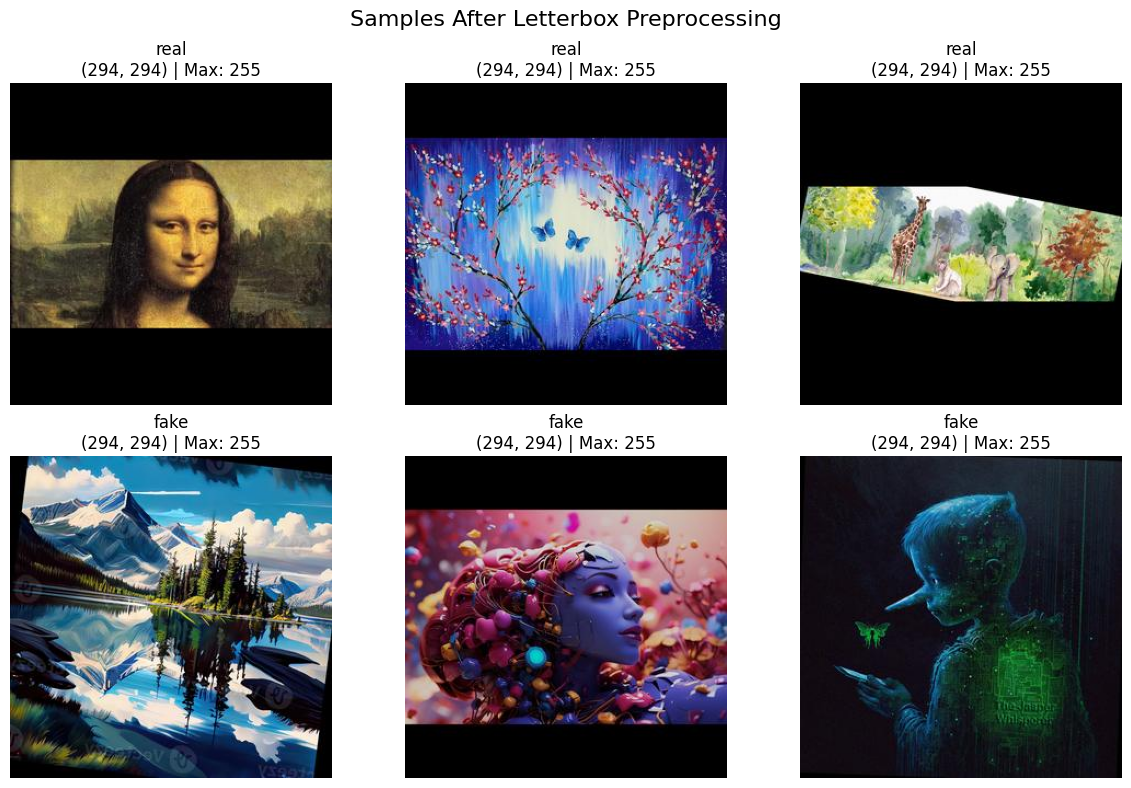

In [10]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_preprocessed_samples(base_path, num_samples=3):
    classes = ['real', 'fake']
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, 8))
    
    for i, label in enumerate(classes):
        folder = os.path.join(base_path, label)
        if not os.path.exists(folder): continue
        
        samples = random.sample(os.listdir(folder), min(num_samples, len(os.listdir(folder))))
        
        for j, img_name in enumerate(samples):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)
            img_array = np.array(img)
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{label}\n{img.size} | Max: {img_array.max()}")
            axes[i, j].axis('off')
            
    plt.suptitle("Samples After Letterbox Preprocessing", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the training output
visualize_preprocessed_samples(TRAIN_OUT)


Total Images Analyzed: 1878
Potential Dark Outliers: 35
Potential Blank/Low Contrast Outliers: 0


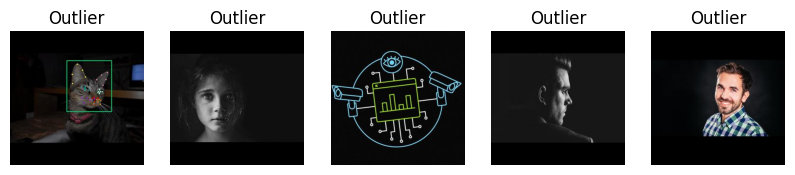

In [11]:
def analyze_outliers(base_path):
    stats = []
    paths = []
    
    for label in ['real', 'fake']:
        folder = os.path.join(base_path, label)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = np.array(Image.open(img_path)).astype(np.float32) / 255.0
            
            # Calculate mean brightness and standard deviation (contrast)
            stats.append([np.mean(img), np.std(img)])
            paths.append(img_path)
            
    stats = np.array(stats)
    means = stats[:, 0]
    stds = stats[:, 1]
    
    # Define outliers: Brightness < 0.1 (too dark) or Std < 0.05 (low contrast/blank)
    dark_outliers = np.where(means < 0.1)[0]
    blank_outliers = np.where(stds < 0.05)[0]
    
    print(f"Total Images Analyzed: {len(paths)}")
    print(f"Potential Dark Outliers: {len(dark_outliers)}")
    print(f"Potential Blank/Low Contrast Outliers: {len(blank_outliers)}")
    
    # Visualize a few outliers if they exist
    all_outliers = list(set(dark_outliers) | set(blank_outliers))
    if all_outliers:
        plt.figure(figsize=(10, 4))
        for i, idx in enumerate(all_outliers[:5]):
            plt.subplot(1, 5, i+1)
            plt.imshow(Image.open(paths[idx]))
            plt.title("Outlier")
            plt.axis('off')
        plt.show()
    else:
        print("No significant statistical outliers detected!")

analyze_outliers(TRAIN_OUT)


Analyzing images for visualization...


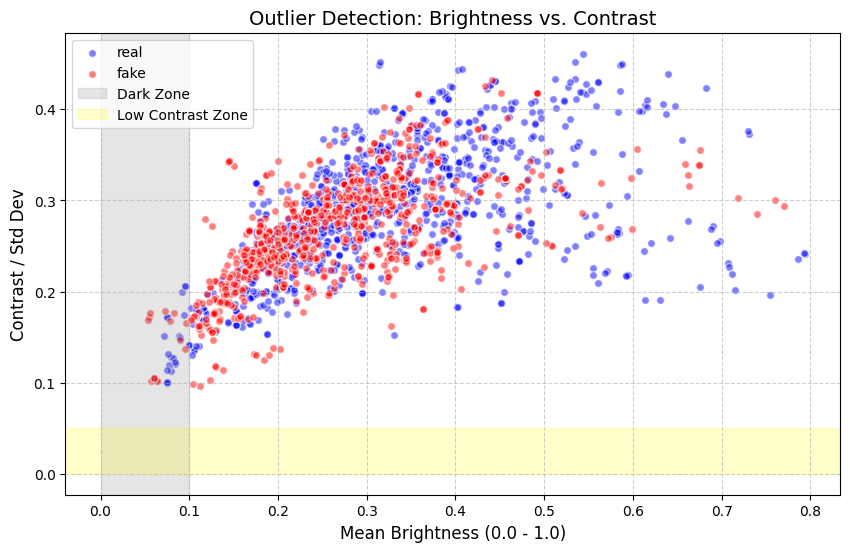

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

def plot_outlier_graph(base_path):
    means = []
    stds = []
    labels = []
    
    print("Analyzing images for visualization...")
    for label in ['real', 'fake']:
        folder = os.path.join(base_path, label)
        if not os.path.exists(folder): continue
        
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            # Load and normalize
            img = np.array(Image.open(img_path)).astype(np.float32) / 255.0
            
            means.append(np.mean(img))
            stds.append(np.std(img))
            labels.append(label)

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot Real images in Blue and Fake in Red
    for cat, color in zip(['real', 'fake'], ['blue', 'red']):
        mask = [l == cat for l in labels]
        plt.scatter(means[mask], stds[mask], alpha=0.5, label=cat, c=color, edgecolors='w', s=30)

    # Highlight the "Outlier Zones"
    plt.axvspan(0, 0.1, color='gray', alpha=0.2, label='Dark Zone') # Too dark
    plt.axhspan(0, 0.05, color='yellow', alpha=0.2, label='Low Contrast Zone') # Too flat/blank
    
    plt.title("Outlier Detection: Brightness vs. Contrast", fontsize=14)
    plt.xlabel("Mean Brightness (0.0 - 1.0)", fontsize=12)
    plt.ylabel("Contrast / Std Dev", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Run the visualization on your preprocessed training data
plot_outlier_graph(TRAIN_OUT)


🚀 PIPELINE RANDOM FOREST AMÉLIORÉ - DÉTECTION DEEPFAKE
📁 Dossier de sauvegarde créé: /kaggle/working/model_outputs/rf_model_20260204_135504

--- Phase 1: Préparation des données (HOG Amélioré) ---
Extraction HOG pour 978 images (real)...


100%|██████████| 978/978 [00:07<00:00, 124.99it/s]


Extraction HOG pour 900 images (fake)...


100%|██████████| 900/900 [00:07<00:00, 123.35it/s]


Extraction HOG pour 110 images (real)...


100%|██████████| 110/110 [00:00<00:00, 126.71it/s]


Extraction HOG pour 388 images (fake)...


100%|██████████| 388/388 [00:03<00:00, 125.20it/s]



📦 Données chargées:
   Train: 1878 échantillons, 21170 features
   Test:  498 échantillons, 21170 features

   Distribution Train - Real: 978, Fake: 900
   Distribution Test  - Real: 110, Fake: 388

--- Phase 2: Normalisation des Features ---
✅ Features normalisées (moyenne=0, écart-type=1)

--- Phase 3: Validation Croisée (5-Fold) ---
✅ Scores CV: [0.69414894 0.71276596 0.72074468 0.68533333 0.704     ]
✅ Moyenne CV: 0.7034 (+/- 0.0253)

--- Phase 4: Entraînement du Modèle ---
✅ Modèle entraîné avec 300 arbres
✅ OOB Score: 0.6970
✅ Modèle sauvegardé en .pth: /kaggle/working/model_outputs/rf_model_20260204_135504/models/random_forest_model.pth
✅ Scaler sauvegardé en .pth: /kaggle/working/model_outputs/rf_model_20260204_135504/models/scaler.pth
✅ Backup .pkl sauvegardé: /kaggle/working/model_outputs/rf_model_20260204_135504/models/random_forest_model.pkl
✅ Paramètres sauvegardés: /kaggle/working/model_outputs/rf_model_20260204_135504/models/model_parameters.json

--- Phase 5: Évaluatio

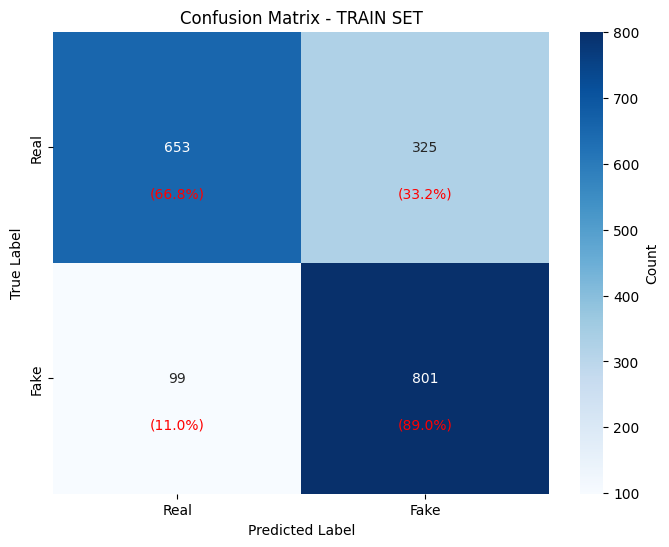

✅ Matrice de confusion sauvegardée: /kaggle/working/model_outputs/rf_model_20260204_135504/visualizations/confusion_matrix_test_set.png


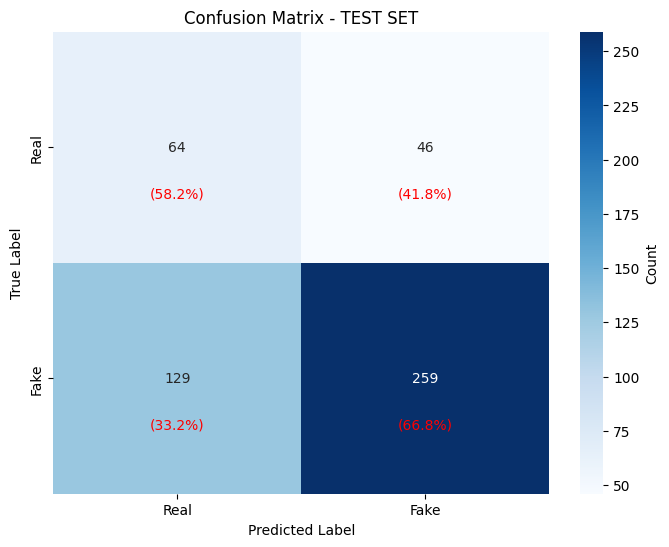

✅ Courbe ROC sauvegardée: /kaggle/working/model_outputs/rf_model_20260204_135504/visualizations/roc_curve_train_set.png


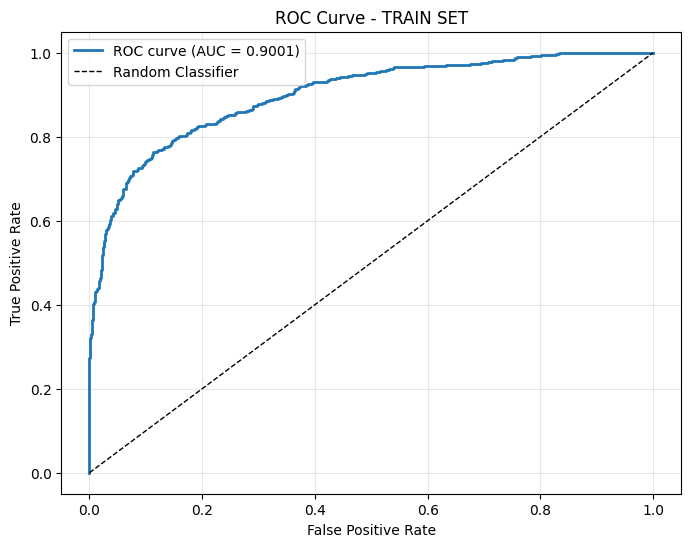

✅ Courbe ROC sauvegardée: /kaggle/working/model_outputs/rf_model_20260204_135504/visualizations/roc_curve_test_set.png


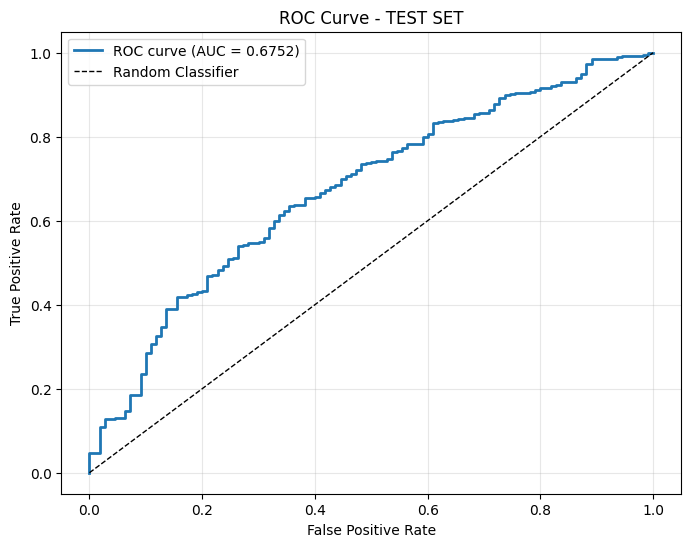

✅ Importance des features sauvegardée: /kaggle/working/model_outputs/rf_model_20260204_135504/visualizations/feature_importance.png


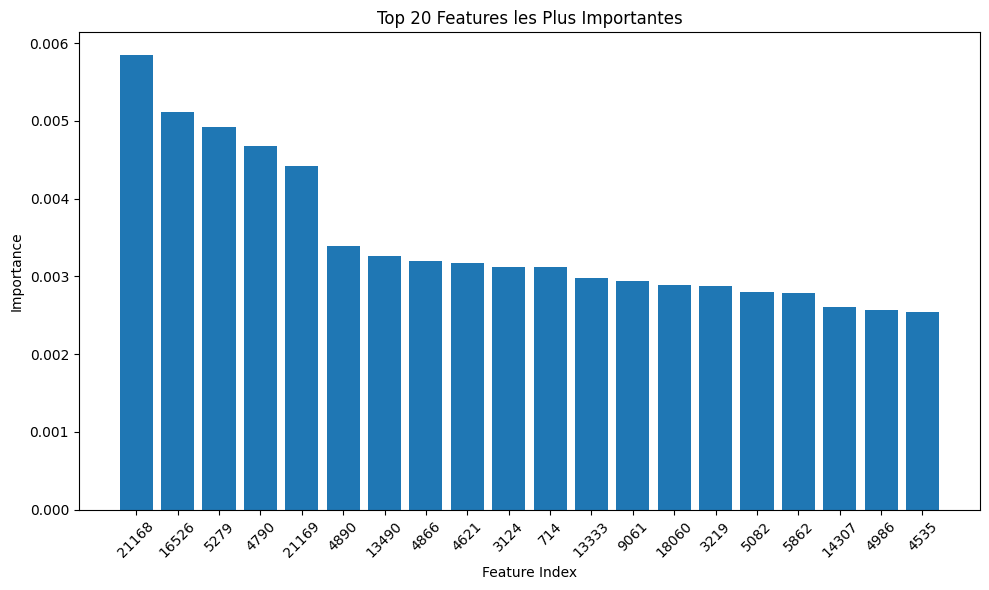

✅ Scores CV sauvegardés: /kaggle/working/model_outputs/rf_model_20260204_135504/visualizations/cv_scores.png


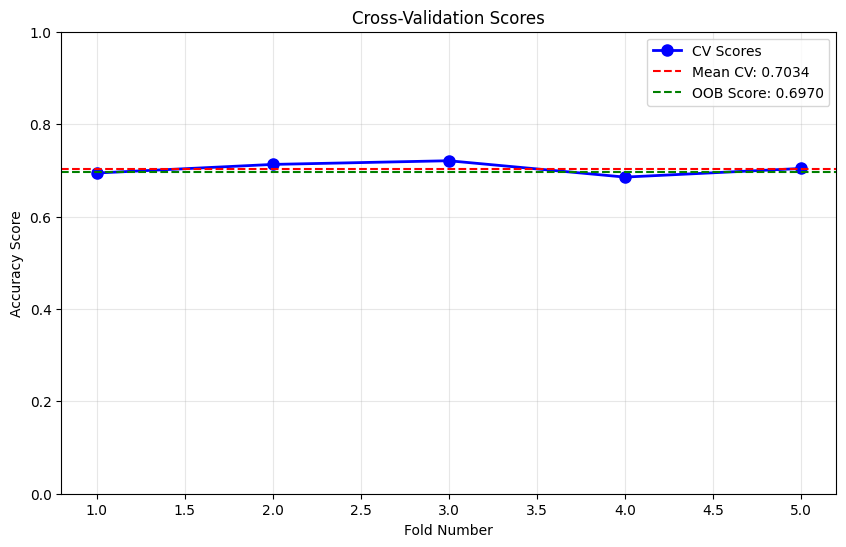


🔍 DIAGNOSTIC OVERFITTING

📊 Écart Train-Test:
   Train Accuracy: 0.7742
   Test Accuracy:  0.6486
   Écart:          0.1256 (12.56%)

⚡ Léger overfitting (écart 5-15%)
   Le modèle est acceptable mais pourrait être amélioré
✅ Rapport d'entraînement sauvegardé: /kaggle/working/model_outputs/rf_model_20260204_135504/training_report.txt
✅ README sauvegardé: /kaggle/working/model_outputs/rf_model_20260204_135504/README.md

✅ PIPELINE TERMINÉ
📁 Tous les fichiers sont dans: /kaggle/working/model_outputs/rf_model_20260204_135504

📦 CONTENU DU DOSSIER DE SAUVEGARDE:
📁 rf_model_20260204_135504/
  📄 README.md
  📄 training_report.txt
  📁 visualizations/
    📄 confusion_matrix_test_set.png
    📄 cv_scores.png
    📄 confusion_matrix_train_set.png
    📄 roc_curve_train_set.png
    📄 roc_curve_test_set.png
    📄 feature_importance.png
  📁 metrics/
    📄 data_statistics.json
    📄 feature_importance.json
    📄 train_metrics.json
    📄 feature_importance.pth
    📄 test_metrics.json
  📁 models/
    📄 s

In [13]:
import os
import numpy as np
import json
import joblib
import pickle
import torch
from datetime import datetime
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, log_loss, classification_report, 
                              confusion_matrix, roc_auc_score, f1_score, 
                              precision_score, recall_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from skimage.feature import hog
from skimage.color import rgb2gray
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Chemins définis par l'utilisateur
PREPROCESSED_DIR = "/kaggle/working/deepfake_preprocessed"
TRAIN_OUT = os.path.join(PREPROCESSED_DIR, "train")
TEST_OUT = os.path.join(PREPROCESSED_DIR, "test")

# Dossier de sauvegarde des modèles et résultats
MODEL_OUTPUT_DIR = "/kaggle/working/model_outputs"

def create_output_directory():
    """
    Crée un dossier horodaté pour sauvegarder tous les outputs
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join(MODEL_OUTPUT_DIR, f"rf_model_{timestamp}")
    
    # Créer les sous-dossiers
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "metrics"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "models"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "predictions"), exist_ok=True)
    
    print(f"📁 Dossier de sauvegarde créé: {output_dir}")
    return output_dir

def save_model_and_scaler(model, scaler, output_dir):
    """
    Sauvegarde le modèle et le scaler en format .pth
    """
    # Sauvegarde en format .pth (PyTorch-style)
    model_path = os.path.join(output_dir, "models", "random_forest_model.pth")
    scaler_path = os.path.join(output_dir, "models", "scaler.pth")
    
    # Créer un dictionnaire de checkpoint (style PyTorch)
    model_checkpoint = {
        'model_state': model,
        'model_type': 'RandomForestClassifier',
        'sklearn_version': model.__class__.__module__,
        'params': model.get_params(),
        'n_features': model.n_features_in_,
        'n_classes': model.n_classes_,
        'feature_importances': model.feature_importances_.copy(),
        'oob_score': model.oob_score_ if hasattr(model, 'oob_score_') else None,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    scaler_checkpoint = {
        'scaler_state': scaler,
        'scaler_type': 'StandardScaler',
        'mean': scaler.mean_.copy(),
        'scale': scaler.scale_.copy(),
        'var': scaler.var_.copy(),
        'n_features': scaler.n_features_in_,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Sauvegarde avec torch.save (format .pth)
    torch.save(model_checkpoint, model_path)
    torch.save(scaler_checkpoint, scaler_path)
    
    print(f"✅ Modèle sauvegardé en .pth: {model_path}")
    print(f"✅ Scaler sauvegardé en .pth: {scaler_path}")
    
    # Sauvegarde également en .pkl pour compatibilité
    model_pkl_path = os.path.join(output_dir, "models", "random_forest_model.pkl")
    scaler_pkl_path = os.path.join(output_dir, "models", "scaler.pkl")
    joblib.dump(model, model_pkl_path)
    joblib.dump(scaler, scaler_pkl_path)
    print(f"✅ Backup .pkl sauvegardé: {model_pkl_path}")
    
    # Sauvegarde des paramètres du modèle en JSON
    params_path = os.path.join(output_dir, "models", "model_parameters.json")
    params_dict = model.get_params()
    # Convertir les valeurs non-sérialisables en string
    params_dict_serializable = {k: str(v) if not isinstance(v, (int, float, str, bool, type(None))) else v 
                                for k, v in params_dict.items()}
    with open(params_path, 'w') as f:
        json.dump(params_dict_serializable, f, indent=4)
    print(f"✅ Paramètres sauvegardés: {params_path}")

def load_model_from_pth(model_path, scaler_path):
    """
    Fonction pour charger le modèle depuis le format .pth
    
    Usage:
        model, scaler = load_model_from_pth('models/random_forest_model.pth', 'models/scaler.pth')
    """
    # CORRECTION: Ajouter weights_only=False pour PyTorch 2.6+
    # Ceci est sûr car nous contrôlons la source du fichier
    try:
        # Méthode 1: weights_only=False (pour nos propres fichiers de confiance)
        model_checkpoint = torch.load(model_path, weights_only=False)
        scaler_checkpoint = torch.load(scaler_path, weights_only=False)
    except Exception as e:
        print(f"⚠️ Erreur avec la méthode 1: {e}")
        print("📝 Tentative avec safe_globals...")
        
        # Méthode 2: Utiliser safe_globals
        with torch.serialization.safe_globals([RandomForestClassifier, StandardScaler]):
            model_checkpoint = torch.load(model_path)
            scaler_checkpoint = torch.load(scaler_path)
    
    # Extraire le modèle et le scaler
    model = model_checkpoint['model_state']
    scaler = scaler_checkpoint['scaler_state']
    
    print(f"✅ Modèle chargé depuis: {model_path}")
    print(f"   - Type: {model_checkpoint['model_type']}")
    print(f"   - Features: {model_checkpoint['n_features']}")
    print(f"   - Classes: {model_checkpoint['n_classes']}")
    print(f"   - OOB Score: {model_checkpoint['oob_score']}")
    print(f"   - Date: {model_checkpoint['timestamp']}")
    
    return model, scaler

def save_metrics_to_json(metrics_dict, output_dir, set_name):
    """
    Sauvegarde les métriques en JSON
    """
    metrics_path = os.path.join(output_dir, "metrics", f"{set_name.lower()}_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics_dict, f, indent=4)
    print(f"✅ Métriques {set_name} sauvegardées: {metrics_path}")

def save_predictions(y_true, y_pred, y_probs, output_dir, set_name):
    """
    Sauvegarde les prédictions en format .pth et autres formats
    """
    # Sauvegarde en format .pth (PyTorch)
    predictions_checkpoint = {
        'y_true': torch.tensor(y_true.copy()),
        'y_pred': torch.tensor(y_pred.copy()),
        'y_probs': torch.tensor(y_probs.copy()),
        'set_name': set_name,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    pred_pth_path = os.path.join(output_dir, "predictions", f"{set_name.lower()}_predictions.pth")
    torch.save(predictions_checkpoint, pred_pth_path)
    print(f"✅ Prédictions {set_name} sauvegardées en .pth: {pred_pth_path}")
    
    # Sauvegarde aussi en JSON pour lisibilité
    predictions_dict = {
        'y_true': y_true.tolist(),
        'y_pred': y_pred.tolist(),
        'y_probs': y_probs.tolist()
    }
    pred_json_path = os.path.join(output_dir, "predictions", f"{set_name.lower()}_predictions.json")
    with open(pred_json_path, 'w') as f:
        json.dump(predictions_dict, f, indent=4)
    
    # Sauvegarde aussi en format numpy
    np_path = os.path.join(output_dir, "predictions", f"{set_name.lower()}_predictions.npz")
    np.savez(np_path, y_true=y_true, y_pred=y_pred, y_probs=y_probs)

def save_training_report(output_dir, report_content):
    """
    Sauvegarde le rapport complet d'entraînement
    """
    report_path = os.path.join(output_dir, "training_report.txt")
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report_content)
    print(f"✅ Rapport d'entraînement sauvegardé: {report_path}")

def extract_enhanced_hog_features(img_path, target_size=(128, 128)):
    """
    Extraction de features HOG améliorées avec paramètres optimisés
    """
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img)
        gray_img = rgb2gray(img_array)
        
        # HOG avec paramètres plus discriminants
        features = hog(
            gray_img, 
            orientations=12,
            pixels_per_cell=(8, 8),
            cells_per_block=(3, 3),
            visualize=False,
            feature_vector=True,
            block_norm='L2-Hys'
        )
        
        # Ajout de statistiques simples comme features supplémentaires
        mean_intensity = np.mean(gray_img)
        std_intensity = np.std(gray_img)
        
        # Combinaison des features
        combined_features = np.concatenate([
            features,
            [mean_intensity, std_intensity]
        ])
        
        return combined_features
    except Exception as e:
        print(f"Erreur lors du traitement: {e}")
        return None

def load_data(base_path, max_samples_per_class=None):
    """
    Chargement des données avec option de limitation pour équilibrage
    """
    X, y = [], []
    classes = {'real': 0, 'fake': 1}
    
    if not os.path.exists(base_path):
        return None, None
    
    for label_name, label_idx in classes.items():
        folder_path = os.path.join(base_path, label_name)
        if not os.path.exists(folder_path):
            continue
            
        files = [f for f in os.listdir(folder_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Limitation si spécifiée (pour équilibrage)
        if max_samples_per_class and len(files) > max_samples_per_class:
            np.random.seed(42)
            files = np.random.choice(files, max_samples_per_class, replace=False)
        
        print(f"Extraction HOG pour {len(files)} images ({label_name})...")
        for file_name in tqdm(files):
            features = extract_enhanced_hog_features(os.path.join(folder_path, file_name))
            if features is not None:
                X.append(features)
                y.append(label_idx)
    
    return np.array(X), np.array(y)

def plot_confusion_matrix(cm, set_name, output_dir=None):
    """
    Affichage de la matrice de confusion
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {set_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Ajout des pourcentages
    for i in range(2):
        for j in range(2):
            total = cm[i].sum()
            percentage = (cm[i, j] / total) * 100 if total > 0 else 0
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', color='red', fontsize=10)
    
    if output_dir:
        save_path = os.path.join(output_dir, "visualizations", f"confusion_matrix_{set_name.lower().replace(' ', '_')}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Matrice de confusion sauvegardée: {save_path}")
    
    plt.show()
    plt.close()

def plot_roc_curve(y_true, y_probs, set_name, output_dir=None):
    """
    Affichage de la courbe ROC
    """
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    auc = roc_auc_score(y_true, y_probs[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {set_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    
    if output_dir:
        save_path = os.path.join(output_dir, "visualizations", f"roc_curve_{set_name.lower().replace(' ', '_')}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Courbe ROC sauvegardée: {save_path}")
    
    plt.show()
    plt.close()

def print_detailed_metrics(y_true, y_pred, y_probs, set_name, output_dir=None):
    """
    Affichage détaillé de toutes les métriques avec sauvegarde
    """
    print(f"\n{'='*60}")
    print(f"📊 RAPPORT DÉTAILLÉ - {set_name.upper()}")
    print(f"{'='*60}\n")
    
    # Métriques globales
    acc = accuracy_score(y_true, y_pred)
    loss = log_loss(y_true, y_probs)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs[:, 1])
    
    print("📈 Métriques Globales:")
    print(f"   Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC-ROC:   {auc:.4f}")
    print(f"   Log Loss:  {loss:.4f}")
    
    # Rapport de classification détaillé
    print(f"\n📋 Classification Report:")
    class_report = classification_report(y_true, y_pred, 
                                target_names=['Real', 'Fake'],
                                digits=4, output_dict=True)
    print(classification_report(y_true, y_pred, 
                                target_names=['Real', 'Fake'],
                                digits=4))
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    print(f"🎯 Confusion Matrix:")
    print(f"                Predicted")
    print(f"              Real    Fake")
    print(f"Actual Real   {cm[0,0]:4d}    {cm[0,1]:4d}")
    print(f"       Fake   {cm[1,0]:4d}    {cm[1,1]:4d}")
    
    # Statistiques détaillées
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\n📊 Statistiques Détaillées:")
    print(f"   True Positives:  {tp:4d}")
    print(f"   True Negatives:  {tn:4d}")
    print(f"   False Positives: {fp:4d}")
    print(f"   False Negatives: {fn:4d}")
    print(f"   Sensitivity (TPR): {sensitivity:.4f}")
    print(f"   Specificity (TNR): {specificity:.4f}")
    
    # Sauvegarde des métriques
    if output_dir:
        metrics_dict = {
            'accuracy': float(acc),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1),
            'auc_roc': float(auc),
            'log_loss': float(loss),
            'confusion_matrix': cm.tolist(),
            'true_positives': int(tp),
            'true_negatives': int(tn),
            'false_positives': int(fp),
            'false_negatives': int(fn),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'classification_report': class_report
        }
        save_metrics_to_json(metrics_dict, output_dir, set_name)
    
    return cm

def plot_feature_importance(model, output_dir=None, top_n=20):
    """
    Affichage de l'importance des features
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(10, 6))
    plt.title(f'Top {top_n} Features les Plus Importantes')
    plt.bar(range(top_n), importances[indices])
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.xticks(range(top_n), indices, rotation=45)
    plt.tight_layout()
    
    if output_dir:
        save_path = os.path.join(output_dir, "visualizations", "feature_importance.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Importance des features sauvegardée: {save_path}")
    
    plt.show()
    plt.close()
    
    # Sauvegarde des valeurs d'importance en .pth
    if output_dir:
        importance_checkpoint = {
            'feature_indices': torch.tensor(indices.copy()),
            'importance_values': torch.tensor(importances[indices].copy()),
            'all_importances': torch.tensor(importances.copy()),
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        importance_pth_path = os.path.join(output_dir, "metrics", "feature_importance.pth")
        torch.save(importance_checkpoint, importance_pth_path)
        
        # Aussi en JSON pour lisibilité
        importance_dict = {
            'feature_indices': indices.tolist(),
            'importance_values': importances[indices].tolist()
        }
        importance_json_path = os.path.join(output_dir, "metrics", "feature_importance.json")
        with open(importance_json_path, 'w') as f:
            json.dump(importance_dict, f, indent=4)

def plot_training_history(cv_scores, oob_score, output_dir=None):
    """
    Graphique des scores de validation croisée
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores) + 1), cv_scores, 'bo-', linewidth=2, markersize=8, label='CV Scores')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean CV: {cv_scores.mean():.4f}')
    plt.axhline(y=oob_score, color='g', linestyle='--', label=f'OOB Score: {oob_score:.4f}')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy Score')
    plt.title('Cross-Validation Scores')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim([0, 1])
    
    if output_dir:
        save_path = os.path.join(output_dir, "visualizations", "cv_scores.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Scores CV sauvegardés: {save_path}")
    
    plt.show()
    plt.close()

def run_enhanced_rf_pipeline():
    print("="*80)
    print("🚀 PIPELINE RANDOM FOREST AMÉLIORÉ - DÉTECTION DEEPFAKE")
    print("="*80)
    
    # Créer le dossier de sauvegarde
    output_dir = create_output_directory()
    
    # Buffer pour le rapport
    report_lines = []
    report_lines.append("="*80)
    report_lines.append("RAPPORT D'ENTRAÎNEMENT - RANDOM FOREST")
    report_lines.append(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report_lines.append("="*80 + "\n")
    
    # ========================
    # Phase 1: Chargement des données
    # ========================
    print("\n--- Phase 1: Préparation des données (HOG Amélioré) ---")
    report_lines.append("\n--- PHASE 1: PRÉPARATION DES DONNÉES ---")
    
    X_train, y_train = load_data(TRAIN_OUT)
    X_test, y_test = load_data(TEST_OUT)
    
    # Vérification et simulation si nécessaire
    if X_train is None or len(X_train) == 0:
        print("\n⚠️  [SIMULATION] Utilisation de données synthétiques...")
        X_train = np.random.rand(500, 100)
        y_train = np.random.randint(0, 2, 500)
        X_test = np.random.rand(100, 100)
        y_test = np.random.randint(0, 2, 100)
        report_lines.append("⚠️ DONNÉES SYNTHÉTIQUES UTILISÉES")
    
    info = f"\n📦 Données chargées:"
    info += f"\n   Train: {X_train.shape[0]} échantillons, {X_train.shape[1]} features"
    info += f"\n   Test:  {X_test.shape[0]} échantillons, {X_test.shape[1]} features"
    info += f"\n\n   Distribution Train - Real: {np.sum(y_train==0)}, Fake: {np.sum(y_train==1)}"
    info += f"\n   Distribution Test  - Real: {np.sum(y_test==0)}, Fake: {np.sum(y_test==1)}"
    print(info)
    report_lines.append(info)
    
    # Sauvegarde des statistiques des données
    data_stats = {
        'train_samples': int(X_train.shape[0]),
        'test_samples': int(X_test.shape[0]),
        'num_features': int(X_train.shape[1]),
        'train_real': int(np.sum(y_train==0)),
        'train_fake': int(np.sum(y_train==1)),
        'test_real': int(np.sum(y_test==0)),
        'test_fake': int(np.sum(y_test==1))
    }
    stats_path = os.path.join(output_dir, "metrics", "data_statistics.json")
    with open(stats_path, 'w') as f:
        json.dump(data_stats, f, indent=4)
    
    # ========================
    # Phase 2: Normalisation
    # ========================
    print("\n--- Phase 2: Normalisation des Features ---")
    report_lines.append("\n--- PHASE 2: NORMALISATION ---")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("✅ Features normalisées (moyenne=0, écart-type=1)")
    report_lines.append("✅ Features normalisées avec StandardScaler")
    
    # ========================
    # Phase 3: Cross-Validation
    # ========================
    print("\n--- Phase 3: Validation Croisée (5-Fold) ---")
    report_lines.append("\n--- PHASE 3: VALIDATION CROISÉE ---")
    
    # Modèle avec régularisation FORTE
    rf_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=3,
        min_samples_split=40,
        min_samples_leaf=30,
        max_features='sqrt',
        max_leaf_nodes=50,
        min_impurity_decrease=0.001,
        bootstrap=True,
        oob_score=True,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    # Cross-validation stratifiée
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, 
                                cv=cv, scoring='accuracy', n_jobs=-1)
    
    cv_info = f"✅ Scores CV: {cv_scores}"
    cv_info += f"\n✅ Moyenne CV: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})"
    print(cv_info)
    report_lines.append(cv_info)
    
    # ========================
    # Phase 4: Entraînement
    # ========================
    print("\n--- Phase 4: Entraînement du Modèle ---")
    report_lines.append("\n--- PHASE 4: ENTRAÎNEMENT ---")
    rf_model.fit(X_train_scaled, y_train)
    
    train_info = f"✅ Modèle entraîné avec {rf_model.n_estimators} arbres"
    train_info += f"\n✅ OOB Score: {rf_model.oob_score_:.4f}"
    print(train_info)
    report_lines.append(train_info)
    
    # Sauvegarde du modèle et du scaler en .pth
    save_model_and_scaler(rf_model, scaler, output_dir)
    
    # ========================
    # Phase 5: Évaluation
    # ========================
    print("\n--- Phase 5: Évaluation Complète ---")
    report_lines.append("\n--- PHASE 5: ÉVALUATION ---")
    
    # Prédictions
    y_train_pred = rf_model.predict(X_train_scaled)
    y_train_probs = rf_model.predict_proba(X_train_scaled)
    
    y_test_pred = rf_model.predict(X_test_scaled)
    y_test_probs = rf_model.predict_proba(X_test_scaled)
    
    # Sauvegarde des prédictions
    save_predictions(y_train, y_train_pred, y_train_probs, output_dir, "TRAIN")
    save_predictions(y_test, y_test_pred, y_test_probs, output_dir, "TEST")
    
    # Métriques détaillées Train
    cm_train = print_detailed_metrics(y_train, y_train_pred, y_train_probs, "TRAIN", output_dir)
    
    # Métriques détaillées Test
    cm_test = print_detailed_metrics(y_test, y_test_pred, y_test_probs, "TEST", output_dir)
    
    # ========================
    # Phase 6: Visualisations
    # ========================
    print("\n--- Phase 6: Génération des Visualisations ---")
    
    # Matrices de confusion
    plot_confusion_matrix(cm_train, "TRAIN SET", output_dir)
    plot_confusion_matrix(cm_test, "TEST SET", output_dir)
    
    # Courbes ROC
    plot_roc_curve(y_train, y_train_probs, "TRAIN SET", output_dir)
    plot_roc_curve(y_test, y_test_probs, "TEST SET", output_dir)
    
    # Feature Importance
    plot_feature_importance(rf_model, output_dir, top_n=20)
    
    # Training History
    plot_training_history(cv_scores, rf_model.oob_score_, output_dir)
    
    # ========================
    # Phase 7: Diagnostic Overfitting
    # ========================
    print("\n" + "="*80)
    print("🔍 DIAGNOSTIC OVERFITTING")
    print("="*80)
    report_lines.append("\n--- DIAGNOSTIC OVERFITTING ---")
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    gap = train_acc - test_acc
    
    diagnostic = f"\n📊 Écart Train-Test:"
    diagnostic += f"\n   Train Accuracy: {train_acc:.4f}"
    diagnostic += f"\n   Test Accuracy:  {test_acc:.4f}"
    diagnostic += f"\n   Écart:          {gap:.4f} ({gap*100:.2f}%)"
    print(diagnostic)
    report_lines.append(diagnostic)
    
    if gap > 0.15:
        warning = "\n⚠️  OVERFITTING DÉTECTÉ (écart > 15%)"
        warning += "\n\n💡 Recommandations:"
        warning += "\n   1. Augmenter min_samples_split et min_samples_leaf"
        warning += "\n   2. Réduire max_depth"
        warning += "\n   3. Collecter plus de données d'entraînement"
        warning += "\n   4. Utiliser de l'augmentation de données"
        warning += "\n   5. Essayer des features différentes ou simplifiées"
        print(warning)
        report_lines.append(warning)
    elif gap > 0.05:
        info = "\n⚡ Léger overfitting (écart 5-15%)"
        info += "\n   Le modèle est acceptable mais pourrait être amélioré"
        print(info)
        report_lines.append(info)
    else:
        success = "\n✅ PAS D'OVERFITTING SIGNIFICATIF"
        success += "\n   Le modèle généralise bien!"
        print(success)
        report_lines.append(success)
    
    # Sauvegarde du rapport complet
    report_content = "\n".join(report_lines)
    save_training_report(output_dir, report_content)
    
    # Sauvegarde d'un fichier README
    readme_lines = [
        "# Random Forest Model - Deepfake Detection\n",
        "## Informations Générales",
        f"- Date d'entraînement: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        f"- Nombre d'échantillons (train): {X_train.shape[0]}",
        f"- Nombre d'échantillons (test): {X_test.shape[0]}",
        f"- Nombre de features: {X_train.shape[1]}\n",
        "## Structure du Dossier",
        "- `models/` : Modèle entraîné (.pth et .pkl) et scaler",
        "- `metrics/` : Métriques en JSON et .pth",
        "- `visualizations/` : Graphiques (confusion matrix, ROC, etc.)",
        "- `predictions/` : Prédictions sauvegardées (.pth, .json, .npz)",
        "- `training_report.txt` : Rapport complet d'entraînement\n",
        "## Comment Charger le Modèle (Format .pth)",
        "```python",
        "import torch",
        "",
        "# Charger le modèle depuis .pth (PyTorch 2.6+)",
        "model_checkpoint = torch.load('models/random_forest_model.pth', weights_only=False)",
        "scaler_checkpoint = torch.load('models/scaler.pth', weights_only=False)",
        "",
        "model = model_checkpoint['model_state']",
        "scaler = scaler_checkpoint['scaler_state']",
        "",
        "# OU utiliser la fonction helper",
        "from your_script import load_model_from_pth",
        "model, scaler = load_model_from_pth('models/random_forest_model.pth', 'models/scaler.pth')",
        "",
        "# Faire des prédictions",
        "X_new_scaled = scaler.transform(X_new)",
        "predictions = model.predict(X_new_scaled)",
        "probabilities = model.predict_proba(X_new_scaled)",
        "```\n",
        "## Alternative: Charger depuis .pkl (Plus simple pour sklearn)",
        "```python",
        "import joblib",
        "",
        "model = joblib.load('models/random_forest_model.pkl')",
        "scaler = joblib.load('models/scaler.pkl')",
        "```\n",
        "## Performances",
        f"- Train Accuracy: {train_acc:.4f}",
        f"- Test Accuracy: {test_acc:.4f}",
        f"- Écart Train-Test: {gap:.4f}",
        f"- OOB Score: {rf_model.oob_score_:.4f}",
        f"- CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})\n",
        "## Contenu du checkpoint .pth",
        "Le fichier .pth contient:",
        "- model_state: L'objet RandomForestClassifier complet",
        "- model_type: Type de modèle",
        "- params: Hyperparamètres",
        "- n_features: Nombre de features",
        "- n_classes: Nombre de classes",
        "- feature_importances: Importance des features",
        "- oob_score: Score out-of-bag",
        "- timestamp: Date de sauvegarde",
        "\n## Note importante (PyTorch 2.6+)",
        "Depuis PyTorch 2.6, il faut utiliser `weights_only=False` pour charger des objets sklearn.",
        "Ceci est sûr car vous contrôlez la source du checkpoint."
    ]
    
    readme_content = "\n".join(readme_lines)
    readme_path = os.path.join(output_dir, "README.md")
    with open(readme_path, 'w') as f:
        f.write(readme_content)
    print(f"✅ README sauvegardé: {readme_path}")
    
    print("\n" + "="*80)
    print("✅ PIPELINE TERMINÉ")
    print(f"📁 Tous les fichiers sont dans: {output_dir}")
    print("="*80)
    
    return rf_model, scaler, output_dir

if __name__ == "__main__":
    model, scaler, output_dir = run_enhanced_rf_pipeline()
    
    print("\n" + "="*80)
    print("📦 CONTENU DU DOSSIER DE SAUVEGARDE:")
    print("="*80)
    for root, dirs, files in os.walk(output_dir):
        level = root.replace(output_dir, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}📁 {os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            print(f'{subindent}📄 {file}')
    
    # Démonstration de chargement
    print("\n" + "="*80)
    print("🔄 TEST DE CHARGEMENT DU MODÈLE .pth")
    print("="*80)
    
    model_path = os.path.join(output_dir, "models", "random_forest_model.pth")
    scaler_path = os.path.join(output_dir, "models", "scaler.pth")
    
    loaded_model, loaded_scaler = load_model_from_pth(model_path, scaler_path)
    print("✅ Modèle rechargé avec succès!")